<h1><center> Alzheimer's (ADNI) Data EDA:</center></h1>

## **Executive Summary**


* File description
* Data quality
* Demographic & Predictors visualizations
* Regression & Correlation
* Survival Curve
* Brain MRI Images




## **Data Description:**

EDA is based on "ADNI Merge" dataset from the [Alzheimer's Disease Neuroimaging Initiative](http://adni.loni.usc.edu/) which is put together by ADNIMERGE R package. The package makes available adnimerge dataframe that contains commonly used variables such as demographics, clinical exam, MRI and PET).  

ADNI data is a merge of four phases (ADNI-1, ADNI-GO, ADNI-2, ADNI-3) that collected results from new participants and monitored existing participants from previous on-going phases. Participants enrolled were between the ages of 55 and 90 and were recruited at 57 sites in the United States and Canada for whom there are key predictors that break down into the following categories:

1. **Demographic Variables**: 
AGE, PTGENDER, PTEDUCAT, PTETHCAT, PTRACCAT, PTMARRY
2. **Brain-Related Variables**: 
Ventricles, Hippocampus, WholeBrain, Entorhinal, Fusiform, MidTemp
3. **Important Biomarkers**: 
Substance, measurement or indicator of biological state that may exist before clinical symptoms arrive. ADNI uses various biomarkers to help predict the onset of AD. Biomarker examples i
APOE4, FDG, PIB, AV45, ABETA, TAU, PTAU
4. **Cognitive Tests**: Everyday Cognitive Scores, MMSE (Mini-Mental State Examination), CDRSB (Clinical Dementia Rating Sum of Boxes), ADAS (Alzheimer’s Disease Assessment Scale–Cognitive subscale) and RAVLT (Rey Auditory Verbal Learning Test), Neuropsychological test scores, Trail Making Test (Part B) Score, Montreal Cognitive Assessment, FAQ (Functional Acitivites Questionnaire)
5. **Clinical Disease States of AD**:
ADNI data marks brain conditions from normal to abnormal which is grouped into 3 states as part of 'DX' response variable: (1) cognitively normal (CN); (2) Mild Cognitive Imparement (MCI); (3) Dementia

*Note: We have not yet been granted access on ADNI but have found ADNIMERGE data to construct initial EDA which can be updated with new dataset once we gain access.*

## **Next Steps:**



*   Acquiring full access to ADNI data (Prof. Bengtsson to help per dicussion)
*   Processing brain image data
*   Creating image data pipeline on Google Cloud (Meeting with Zihao for advice)



In [ ]:
# Run below code if packages are not installed
%%bash
pip install lifelines
pip install statsmodels
pip install itertools
pip install skimage
pip install sklearn
pip install missingno

In [3]:
%matplotlib inline

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from skimage import io
plt.style.use('default')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import itertools

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import missingno as msno
import os

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# load the data
adni_df = pd.read_csv('ADNIMERGE.csv')

## File Description

In [4]:
# Convert file size to human readable format
suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

In [6]:
# File Size

print("File Size:", humansize(os.stat("ADNIMERGE.csv").st_size))
print("Row Count:", len(adni_df), "rows")
print("Col Count:", len(adni_df.columns))

File Size: 9.56 MB
Row Count: 13673 rows
Col Count: 113


## Data Quality



In [0]:
adni_df.head()

,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,DIGITSCOR,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,...,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,LDELTOTAL_BL,DIGITSCOR_bl,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,FLDSTRENG_bl,FSVERSION_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11.0,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,16.0,Not Hisp/Latino,White,Married,0.0,1.36665,NaN,NaN,NaN,NaN,NaN,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,-4.35795,-4.15975,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0.0,0.0,2018-11-08 22:51:22.0
1,3,011_S_0003,bl,11.0,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,18.0,Not Hisp/Latino,White,Married,1.0,1.08355,NaN,NaN,741.5,239.7,22.83,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0.0,0.0,2018-11-08 22:51:22.0
2,3,011_S_0003,m06,11.0,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,18.0,Not Hisp/Latino,White,Married,1.0,1.05803,NaN,NaN,NaN,NaN,NaN,6.0,19.00,30.00,10.0,24.0,19.0,2.0,6.0,100.0000,NaN,19.0,135.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6.0,6.0,2018-11-08 22:51:22.0
3,3,011_S_0003,m12,11.0,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,18.0,Not Hisp/Latino,White,Married,1.0,1.09690,NaN,NaN,601.4,251.7,24.18,3.5,24.00,35.00,10.0,17.0,31.0,2.0,7.0,100.0000,0.0,21.0,126.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.999316,11.96720,12.0,12.0,2018-11-08 22:51:22.0
4,3,011_S_0003,m24,11.0,ADNI1,ADNI1,2007-09-12,AD,81.3,Male,18.0,Not Hisp/Latino,White,Married,1.0,1.03258,NaN,NaN,NaN,NaN,NaN,8.0,25.67,37.67,10.0,19.0,23.0,1.0,5.0,100.0000,0.0,16.0,275.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.58450,-16.16580,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [0]:
adni_df.describe()

,RID,SITE,AGE,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,DIGITSCOR,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,IMAGEUID,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,mPACCdigit,mPACCtrailsB,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,LDELTOTAL_BL,DIGITSCOR_bl,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,FLDSTRENG_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M
count,13673.000000,13673.000000,13671.000000,13673.000000,13280.000000,3509.000000,223.000000,2566.000000,9810.000000,9711.000000,9621.000000,9734.000000,9747.000000,9631.000000,9631.000000,9605.000000,9533.000000,7721.000000,3800.000000,9323.000000,9826.000000,5759.000000,5861.000000,5841.000000,5800.000000,5832.000000,5717.000000,5799.000000,5848.000000,5907.000000,5913.000000,5798.000000,5838.000000,5650.000000,5755.000000,5907.000000,0.0,7955.000000,7447.000000,6804.000000,7.691000e+03,6470.000000,6470.000000,6470.000000,7.955000e+03,9739.000000,9741.000000,13673.000000,13648.000000,13585.000000,13667.000000,13673.000000,13632.000000,13632.000000,13632.000000,13610.000000,13666.000000,7049.000000,13441.000000,13615.000000,13669.000000,13669.000000,0.0,12780.000000,11471.000000,1.303800e+04,11348.000000,11348.000000,11348.000000,1.319800e+04,6513.000000,6583.000000,6579.000000,6555.000000,6580.000000,6436.000000,6537.000000,6581.000000,6561.000000,6567.000000,6476.000000,6514.000000,6258.000000,6415.000000,6558.000000,9678.000000,149.000000,6285.000000,13673.000000,13673.000000,13673.000000,13673.000000
mean,2401.266145,75.581292,73.668664,16.027207,0.532229,1.206679,1.783161,1.190345,2.103364,11.399764,17.440746,5.144134,26.695086,35.057523,4.112761,4.195731,58.424344,8.488408,37.388947,118.457364,5.400163,23.261330,2.052561,1.714454,1.383480,1.404090,1.523608,1.814623,1.669351,2.115106,1.699364,1.584846,1.684178,1.768788,1.969809,1.806283,NaN,238349.291515,42146.102994,6682.109935,1.011850e+06,3444.734158,17147.247295,19204.438022,1.534151e+06,-6.152374,-5.836070,1.306041,9.722413,15.324405,4.877223,27.631975,36.855927,4.488923,4.271787,54.286889,7.816625,40.144843,111.123577,3.217995,-4.990436,-4.760363,NaN,38814.161737,6886.005056,1.026225e+06,3562.398484,17470.103454,19718.345964,1.536371e+06,23.569476,2.104904,1.729311,1.370141,1.396629,1.504928,1.799437,1.673936,2.013536,1.568946,1.406022,1.523150,1.617205,1.804339,1.658906,1.246905,1.588003,1.196754,2.318080,27.759955,27.679295,27.497623
std,1954.081538,116.189055,6.984057,2.812347,0.654378,0.159207,0.422511,0.227314,2.839277,8.440691,11.469921,3.116274,3.924537,13.729610,2.831061,2.583669,38.637636,6.219612,14.417652,77.666900,7.878625,4.723617,0.735013,0.635928,0.538314,0.551258,0.624644,0.750075,0.544140,0.997235,0.828429,0.851240,0.914800,0.979731,1.006503,0.853484,NaN,138018.397775,23269.112377,1240.060365,1.119986e+05,811.710159,2819.191604,3139.342134,1.662853e+05,8.213573,7.859368,1.539337,5.836570,8.624422,2.846530,2.374530,12.116160,2.719659,2.564608,34.696385,5.263663,12.391316,67.696370,5.396495,5.741685,5.474401,NaN,21772.519231,1157.822495,1.091381e+05,769.430046,2652.629860,2961.777179,1.628044e+05,3.915783,0.722528,0.623440,0.526377,0.543767,0.608728,0.731401,0.527941,0.888851,0.700474,0.647759,0.737303,0.824378,0.884010,0.689535,0.144182,0.305423,0.220270,2.401269,28.756179,28.711699,28.538383
min,2.000000,2.000000,54.400000,4.000000,0.000000,0

* A significant portion of patients are missing Everyday Cognition (Ecog) data. 

* Biomarkers (Amyloid Beta, Tau and PTau) are not available for every patient. 

* Not all patients undergo baseline tests resulting in more missing data.



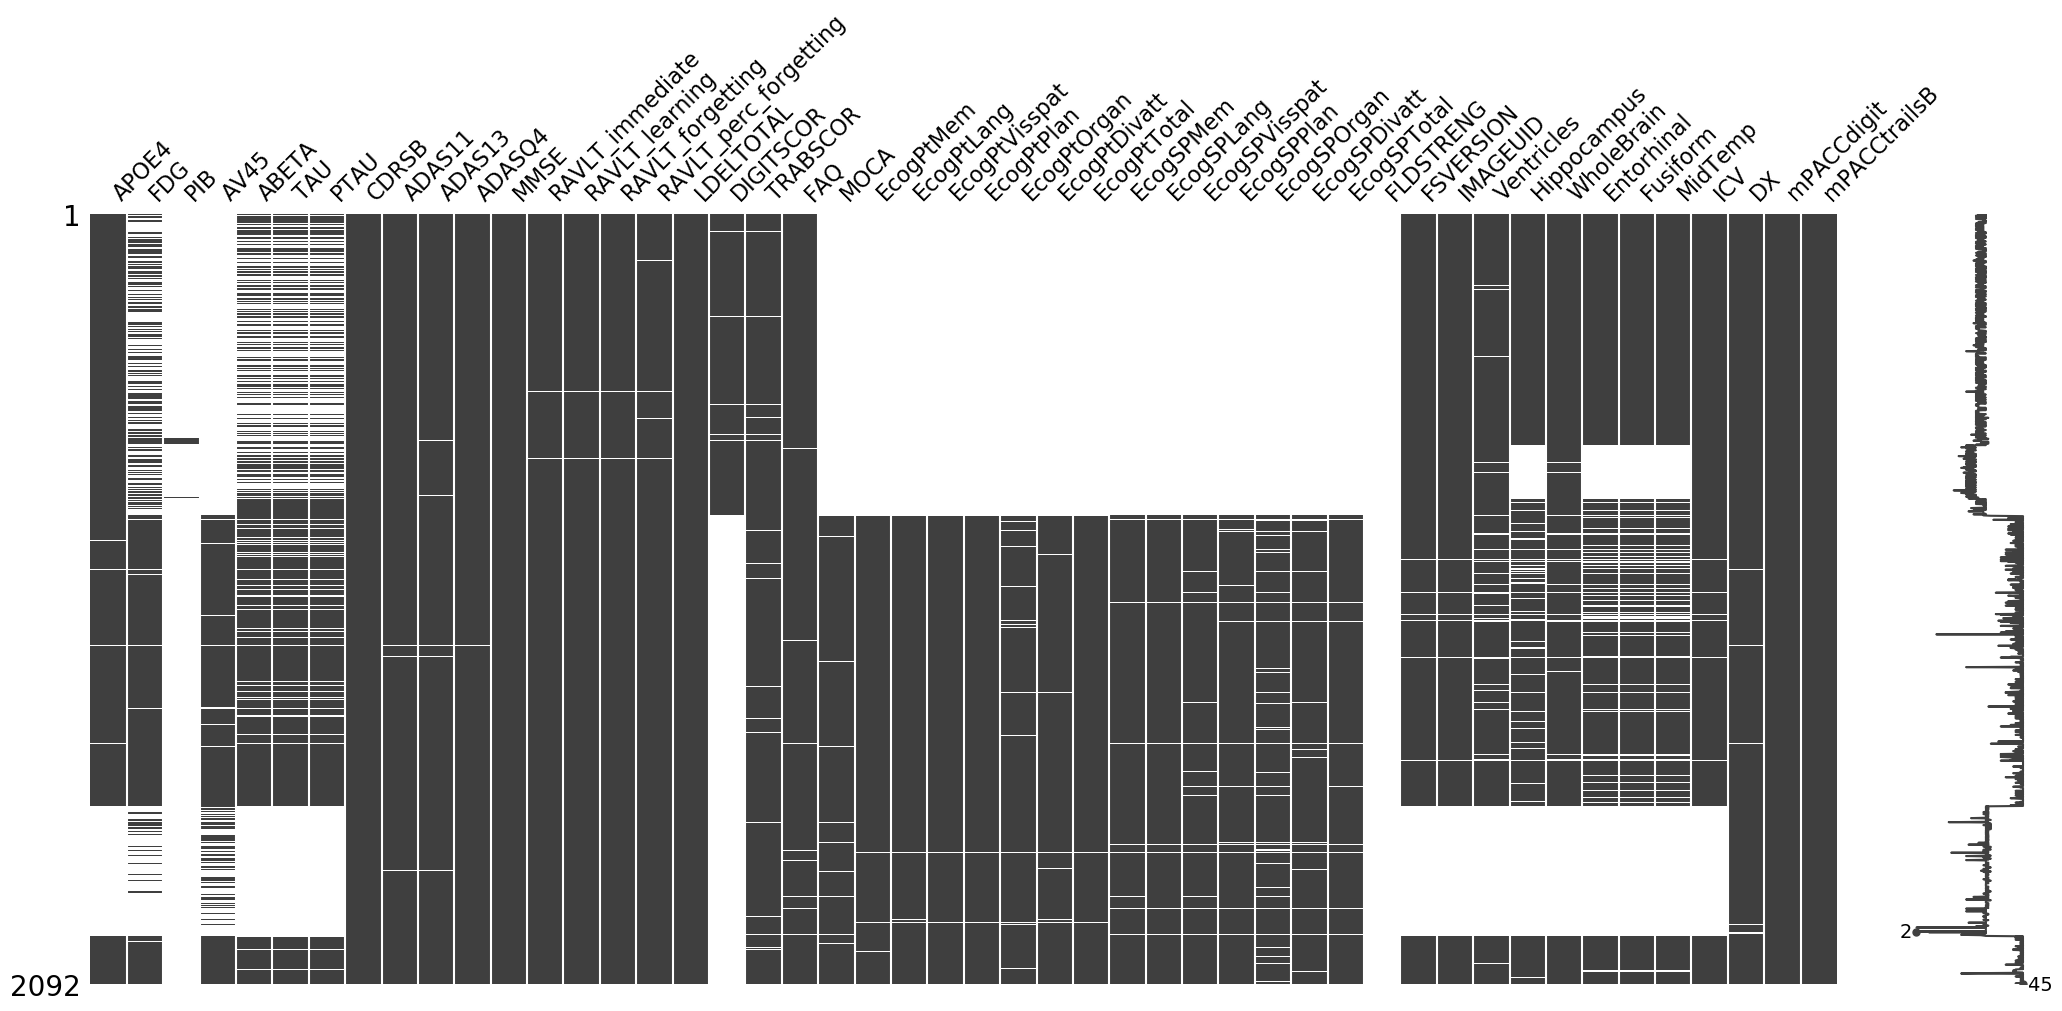

In [17]:
import missingno as msno

# remove baseline variables
adni_df_missingness = adni_df[[col for col in adni_df.columns if col[-3:] != "_bl"]]

# plot missing values for baseline observations, sorted by protocol (i.e. ADNI stage)
keep_cols = list(adni_df_missingness.columns[adni_df_missingness.isna().sum() > 10]) + ['VISCODE','COLPROT']
adni_anymissing = adni_df_missingness.loc[adni_df_missingness.VISCODE == 'bl',keep_cols].sort_values(['VISCODE','COLPROT'])
msno.matrix(adni_anymissing.loc[:, (adni_anymissing.columns != 'VISCODE') & (adni_anymissing.columns != 'COLPROT')])
a = 2

Looking at the data types in our column, we have integers, objects, and floats. However, ABETA, PTAU, and TAU, which we know are quantitative data is being classified as objects.

In [0]:
adni_df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

Looking at the unique values of the TAU, PTAU, and ABETA, we can see that not all values are numeric. The data is not uniform in format. Some entries use the greater than or less than symbol, while others are floats. The same issue exists for the respective baseline columns. By extracting the elements with ">" or "<" we find the specific limits of our data for TAU, ABETA, and PTAU below.

200 < ABETA < 1700, 
8 < PTAU < 120, 
80 < TAU < 1300

Meaning, for any values outside these specific ranges for these columns, data is cutoff. A possible solution to this would be EM algorithm.

In [0]:
adni_df.loc[adni_df['TAU'].str.contains(r"\<|\>", na=False)]['TAU'].unique()

array(['>1300', '<80'], dtype=object)

In [0]:
adni_df.loc[adni_df['PTAU'].str.contains(r"\<|\>", na=False)]['PTAU'].unique()

array(['>120', '<8'], dtype=object)

In [0]:
adni_df.loc[adni_df['ABETA'].str.contains(r"\<|\>", na=False)]['ABETA'].unique()

array(['>1700', '<200'], dtype=object)

In [0]:
# Aggregate data by PROTCOL (Data collection protocol)
protcol_agg = (
    adni_df
    .groupby(['COLPROT'])
    .count(
    )
)
protcol_agg.head()

,RID,PTID,VISCODE,SITE,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,DIGITSCOR,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,...,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,LDELTOTAL_BL,DIGITSCOR_bl,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,FLDSTRENG_bl,FSVERSION_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
COLPROT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ADNI1,5013,5013,5013,5013,5013,5013,5013,5013,5013,5013,5013,5013,5013,5013,1738,223,0,919,919,919,3823,3844,3790,3846,3856,3817,3817,3804,3762,2726,3800,3699,3838,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3549,...,5013,5012,4974,5013,5013,4994,4994,4994,4979,5013,4996,4954,4990,5013,5013,0,5006,4931,4121,4954,4121,4121,4121,5006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2513,2513,2513,2452,88,0,5013,5013,5013,5013,5013
ADNI2,6942,6942,6942,6942,6942,6942,6942,6942,6942,6942,6942,6942,6942,6931,1340,0,1899,1280,1280,1279,4679,4598,4568,4609,4610,4549,4549,4539,4513,3844,0,4394,4691,4506,4583,4567,4529,4559,4462,4532,4571,4616,4622,4538,4564,4421,4497,4618,0,3875,...,6942,6926,6907,6940,6942,6925,6925,6925,6919,6941,1514,6801,6922,6941,6941,0,6858,6552,6153,6761,6051,6051,6051,6858,5367,5415,5411,5388,5410,5283,5371,5411,5398,5403,5325,5356,5154,5273,5394,5677,5677,5677,6133,49,5365,6942,6942,6942,6942,6942
ADNI3,914,914,914,914,914,914,897,912,914,914,914,914,914,535,156,0,406,0,0,0,835,795,791,803,808,794,794,794,792,794,0,774,823,786,813,808,807,809,797,804,811,817,817,798,802,784,794,816,0,0,...,914,907,905,911,914,910,910,910,909,909,117,894,903,912,912,0,532,510,493,527,484,484,484,532,774,789,786,785,788,777,784,788,783,784,776,780,748,772,784,443,443,443,532,3,543,914,914,914,914,914
ADNIGO,804,804,804,804,804,804,804,804,804,804,804,804,804,801,275,0,261,172,172,172,473,474,472,476,473,471,471,468,466,357,0,456,474,467,465,466,464,464,458,463,466,474,474,462,472,445,464,473,0,531,...,804,803,799,803,804,803,803,803,803,803,422,792,800,803,803,0,802,787,704,796,692,692,692,802,372,379,382,382,382,376,382,382,380,380,375,378,356,370,380,537,537,537,561,9,377,804,804,804,804,804


## Demographics & Predictors Description

In [0]:
# Aggregate data by Education
protcol_agg = (
    adni_df
    .groupby(['DX'])['PTID']
    .count()
    .sort_values(ascending=False
    )
)
protcol_agg.head()

DX
MCI         4288
CN          3223
Dementia    2180
Name: PTID, dtype: int64

Looking at the plotted visualizations, we can see the wide spread of points and the difficulty to get a strong relationship between the two; Looking at the plotted visualizations, we can see the wide spread of points and the difficulty to get a strong relationship between the two.

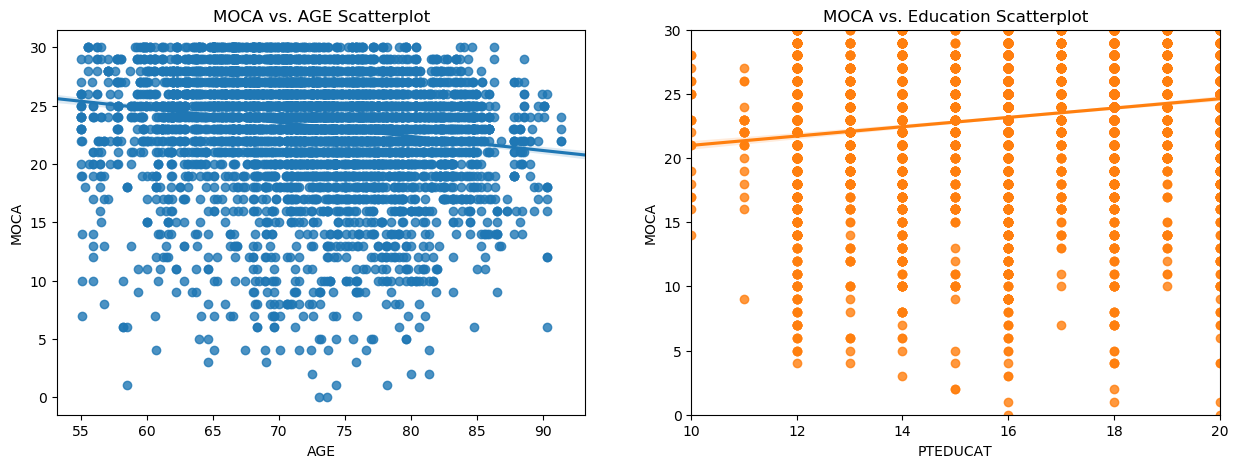

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes = ax.ravel()
sns.regplot(x= "AGE", y = "MOCA", data = adni_df, ax = axes[0]);
sns.regplot(x= "PTEDUCAT", y = "MOCA", data = adni_df, ax=axes[1]);
axes[0].set_title('MOCA vs. AGE Scatterplot')
axes[1].set_title('MOCA vs. Education Scatterplot')
axes[1].set_xlim(10,20)
axes[1].set_ylim(0,30);



* In this part we present distributional graphs on the demographically variables of the patients. It can be seen from the plot that the distribution for age is approximately symmetrical from 50 to 90 and the mean for all patients is 73. Patients studied generally have 12+ years of education and the mean education year is 16. The project involved total number of 1113 males and 979 female, with white people dominated the population group.


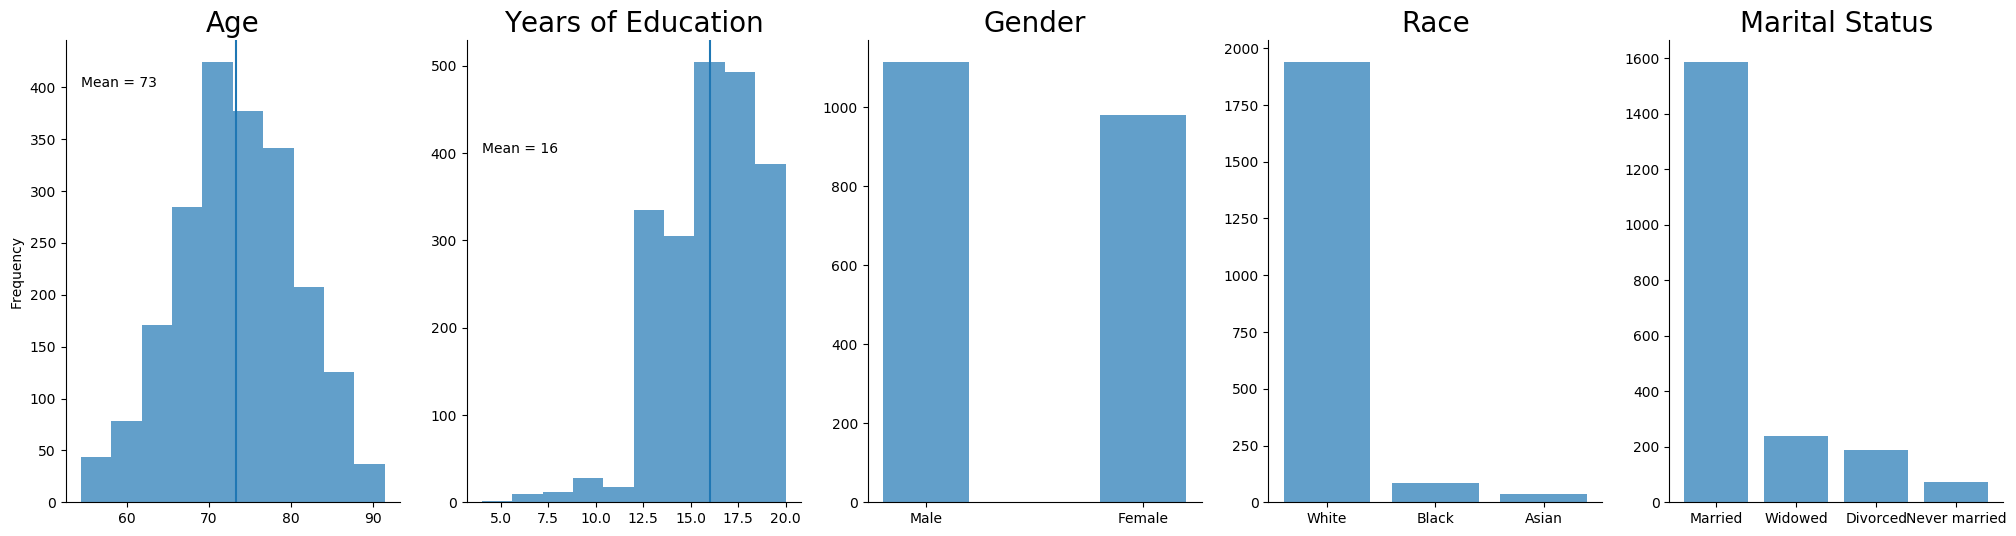

In [18]:
def plot_dist(variable, data, plottype, ax, xlabel, 
              ylabel = '', bins = 10, alpha = 0.7,
              add_mean = False, bar_values = None, 
              width = 0.8):
    """
    Create a plot (histogram or bar plot) for one variable in data
    
    Params:
    -------
    variable  - str, name of variable;
    data      - data set;
    plottype  - str, type of plot 'hist' or 'bar';
    ax        - ax in matplotlib to work on;
    xlabel    - str, name of plot title;
    ylabel    - str, label of y axis;
    bins      - # of bins for hist, default is 10;
    alpha     - transparency of the plot, default is 0.7;
    add_mean  - Boolean, if true add the mean for histogram;
    bar_values- # of categories of interest in bar plot, 
                default is None, which select all data;
    width     - width of bars in barplot, default is 0.8.
    
    Return:
    -------
    A subplot in matplotlib
    """
    
    tmp = data[variable].dropna(axis=0)
    if(plottype == 'hist'):
        ax.hist(tmp, bins = bins, alpha = alpha)
        
    elif(plottype == 'bar'):
        if (bar_values):
            ticks = tmp.value_counts().index.values[:bar_values]
            heights = tmp.value_counts().values[:bar_values]
        else:
            ticks = tmp.value_counts().index.values
            heights = tmp.value_counts().values
            
        ax.bar(ticks, heights, alpha = 0.7, width = width)
    
    if (add_mean):
        ax.axvline(x = tmp.mean(), ymin = 0, ymax = 1)
        ax.text(min(tmp), 400, "Mean = " + str(round(tmp.mean())))
    ax.set_title(xlabel, fontsize = 20)
    if (ylabel):
        ax.set_ylabel(ylabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);

p_data = adni_df[['PTID','AGE', 'PTEDUCAT', 'PTGENDER', 'PTETHCAT', 
                  'PTMARRY', 'PTRACCAT']].drop_duplicates()
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,6))
axes = ax.ravel()
plot_dist("AGE", p_data, 'hist', ax[0], 'Age', ylabel = 'Frequency', add_mean = True)
plot_dist("PTEDUCAT", p_data, 'hist', ax[1], 'Years of Education', add_mean = True)
plot_dist("PTGENDER", p_data, 'bar', ax[2], 'Gender', width = 0.4)
plot_dist("PTRACCAT", p_data, 'bar', ax[3], 'Race', bar_values = 3)
plot_dist("PTMARRY", p_data, 'bar', ax[4], 'Marital Status', bar_values = 4)

**Boxplot 1: AD Status (DX) vs. Age**  
Male patients seem to show signs and also diagnose with AD at a later age than women do.  

**Boxplot 2: AD Status (DX) vs. MMSE**  
Decline in hippocampus volume seems to be more drastic in women with AD than in men


In [8]:
# Group by patients' exam date 
adni_df2 = adni_df.copy()
adni_df2['date'] = adni_df2['EXAMDATE'].apply(lambda x: pd.to_datetime(x).year)
adni_df3 = adni_df2.sort_values(['PTID', 'date'], ascending=False).groupby(['PTID', 'date']).head(1)
adni_df3.shape

(8578, 114)

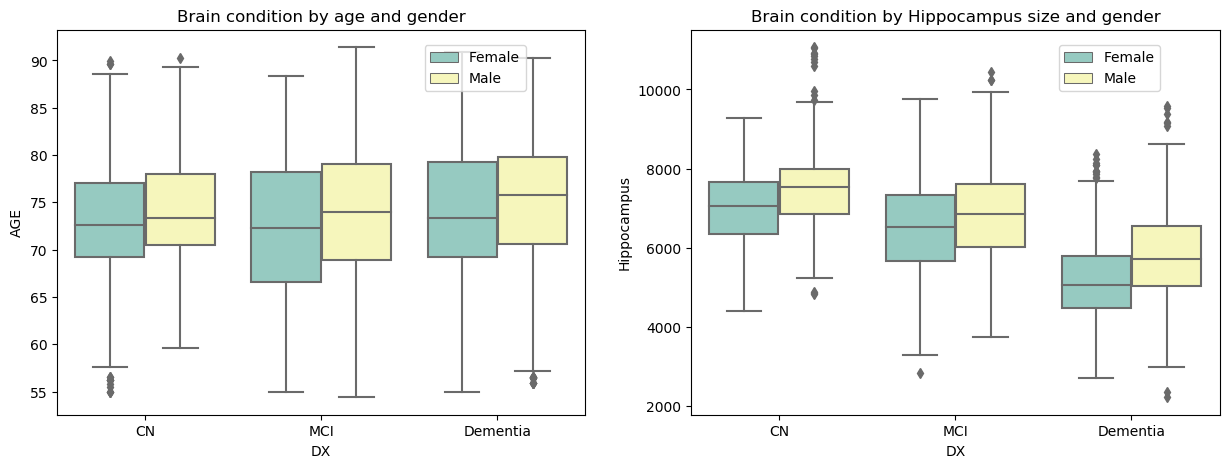

In [12]:
# Patient break-out by diagnostic result (DX)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes = ax.ravel()
gender = sns.boxplot(x="DX", y="AGE", hue="PTGENDER",
                     data=adni_df3, palette="Set3",ax=axes[0])
axes[0].set_title("Brain condition by age and gender")
gender.legend(loc='right', bbox_to_anchor=(.9, .9), ncol=1)

mmse = sns.boxplot(x="DX", y="Hippocampus", hue="PTGENDER",
                   data=adni_df3, palette="Set3",ax=axes[1])
axes[1].set_title("Brain condition by Hippocampus size and gender")
mmse.legend(loc='right', bbox_to_anchor=(.9, .9), ncol=1);

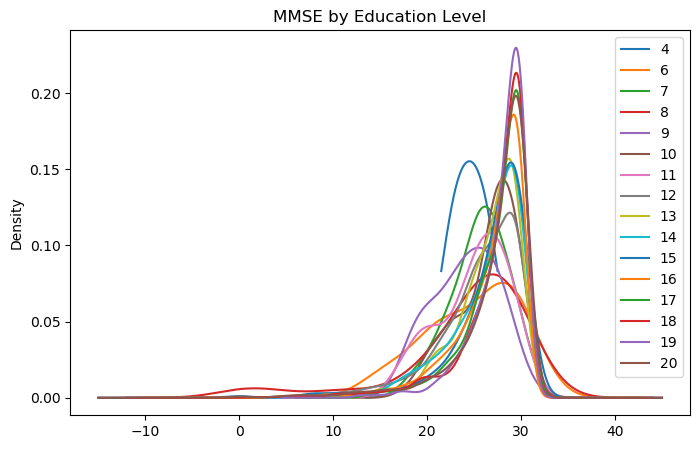

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
adni_df3.groupby([adni_df3.PTEDUCAT]).MMSE.plot.kde()
ax.set_title("MMSE by Education Level")
plt.legend();

The ADNI data documented resutls of a series of cognitive tests including MMSE, CDRSB, RAVLT, mPACC, etc. These tests largely facilitate the diagnosis of patients' condition so the distribution for those test results among different patient group can be very different. The plot below shows the distribution of 4 different tests by different patient groups, we can see that the AD (Alzheimer’s) group and CN (Control)group are largely separable from the results but the distribution of MCL (Mild conditions) will lie in the middle. The data we used below is the baseline group, which decuments the initial diagnosis for each patient.

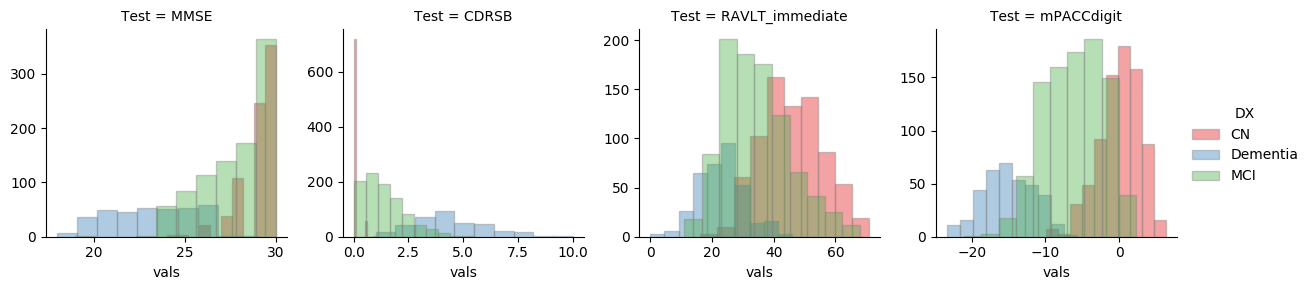

In [0]:
name_dict = {'CN': 'CN', 'Dementia': 'AD', 'MCI': 'MCI'}
baseline_df = adni_df[adni_df['M'] == 0][['MMSE', 'CDRSB', 'RAVLT_immediate', 'mPACCdigit', 'PTID', 'DX']]
df = baseline_df.melt(['PTID', 'DX'], var_name='Test',  value_name='vals')

g = sns.FacetGrid(df, col='Test', hue="DX", palette="Set1", sharex=False, sharey=False)
g = (g.map(plt.hist, "vals", alpha = .4, edgecolor='grey'))
g.add_legend();

In the following chart, we want to find out the conversion between different patient groups. Specifically, we picked out all the patients in ADNI2 and filtered out the total number of patients how had a visit in 2012 and at the same time had a visit record in 2015. By doing this, we ended up with 625 patients, and we created the pivot table below, we can see that after a 4-year period, 91 patients who were initially diagnosed as MCI were confirmed into Dementia group; 31 patients who were initially diagnosed as cognitive normal were confirmed into MCI group.

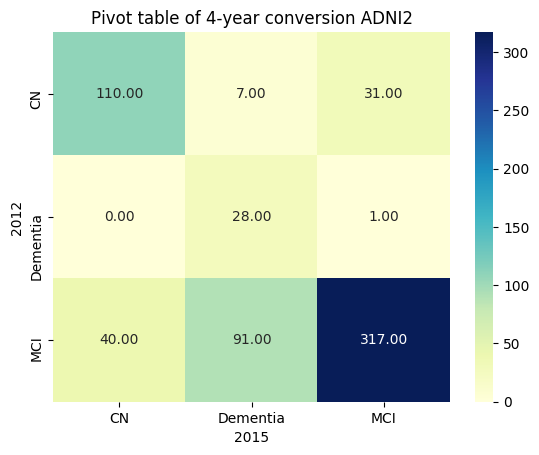

In [0]:
adni_df2 = adni_df.copy()
adni_df2['year'] = adni_df2['EXAMDATE'].apply(lambda x: pd.to_datetime(x).year)
adni_df212 = adni_df2.loc[(adni_df2.COLPROT == "ADNI2") & (adni_df2.year == 2012)]
adni_df215 = adni_df2.loc[(adni_df2.COLPROT == "ADNI2") & (adni_df2.year == 2015)]


adni_pivot = adni_df212[['PTID', 'DX', 'year']].merge(adni_df215[['PTID', 'DX', 'year']], 
                                                      on = 'PTID', how = 'left').dropna()
adni_pivot.columns = ['PTID', 'DX_2012', 'year_2012', 'DX_2015', 'year_2015']

adni_pivot = adni_pivot[['PTID', 'DX_2012', 'DX_2015']].pivot_table(index=['DX_2012'], 
                                                                    columns = ['DX_2015'], 
                                                                    aggfunc='count')\
                                                       .fillna(0)


ax = sns.heatmap(adni_pivot, annot=True, fmt=".2f", cmap="YlGnBu", 
                 xticklabels=['CN', 'Dementia', 'MCI'])
ax.set_xlabel('2015')
ax.set_ylabel('2012')
ax.set_title('Pivot table of 4-year conversion ADNI2');

## Regression and correlation

Running a regression with the dependent variables as demographic information like age and education against MOCA. MOCA (Montreal Cognitive Assessment) Test is a brief 30 question test and helps identify dimentia.

Looking at the model, we have an R-squared of .956. However the p-value for both dependent variables are insignificant. 

In [0]:
test = adni_df[["MOCA","AGE", "PTEDUCAT"]].dropna(how='any',axis=0) 
X = test[["AGE", "PTEDUCAT"]]
y = test["MOCA"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MOCA   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          6.186e+04
Date:                Thu, 20 Feb 2020   Prob (F-statistic):                        0.00
Time:                        17:23:16   Log-Likelihood:                         -17439.
No. Observations:                5757   AIC:                                  3.488e+04
Df Residuals:                    5755   BIC:                                  3.490e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE            0.1455      0.005     30.809      0.000       0.136       0.155
PTEDUCAT       0.7714      0.021     36.930      0.000       0.730       0.812
==============================================================================
Omnibus:                      850.333   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1514.275
Skew:                          -0.955   Prob(JB):                         0.00
Kurtosis:                       4.632   Cond. No.                         24.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We were removing NaNs previously but filling them with 0, we get more significant results, however our R-Squared / Goodness of Fit drops.

In [0]:
test = adni_df[["MOCA","AGE", "PTEDUCAT"]].fillna(0)
X = test[["AGE", "PTEDUCAT"]]
y = test["MOCA"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MOCA   R-squared (uncentered):                   0.410
Model:                            OLS   Adj. R-squared (uncentered):              0.410
Method:                 Least Squares   F-statistic:                              4754.
Date:                Thu, 20 Feb 2020   Prob (F-statistic):                        0.00
Time:                        17:23:18   Log-Likelihood:                         -53183.
No. Observations:               13673   AIC:                                  1.064e+05
Df Residuals:                   13671   BIC:                                  1.064e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE           -0.0297      0.007     -4.373      0.000      -0.043      -0.016
PTEDUCAT       0.7379      0.031     23.907      0.000       0.677       0.798
==============================================================================
Omnibus:                    69618.189   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1846.304
Skew:                           0.426   Prob(JB):                         0.00
Kurtosis:                       1.414   Cond. No.                         23.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Firstly, a new dataframe is created with only variables with integer or float values. We create a correlation matrix and heatmap to see if there are any strong correlations between different variables to catch problems with multicolinearity which can cause issues later on in regression models.

In [0]:
#getting a data frame to filter only integer or floating type variables
data_types = adni_df.dtypes.to_frame().reset_index()

data_types.columns = ['column', 'type']

num_col = data_types.loc[(data_types['type'] == 'float64') | (data_types['type'] == 'int64')]['column']

#subsetting the data
adni_num_df = adni_df[num_col]

#running the correlation matrix
adni_corr_mat = adni_num_df.corr()

Looking at the visualization, the correlation matrix is extremely segmented. This can be a sign of missing values as well as some columns consists of discrete data or 0/1 values. 

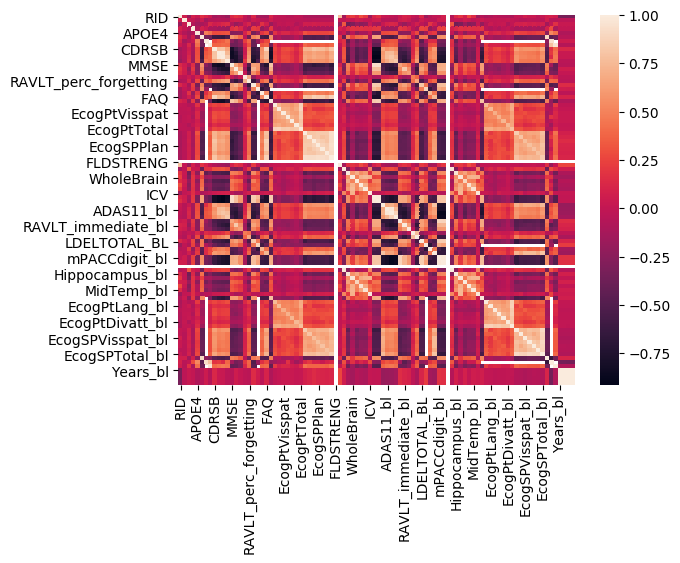

In [0]:
sns.heatmap(adni_corr_mat)

We fill the NaN with 0 and we can see much clearer relationships within the correlation matrix.

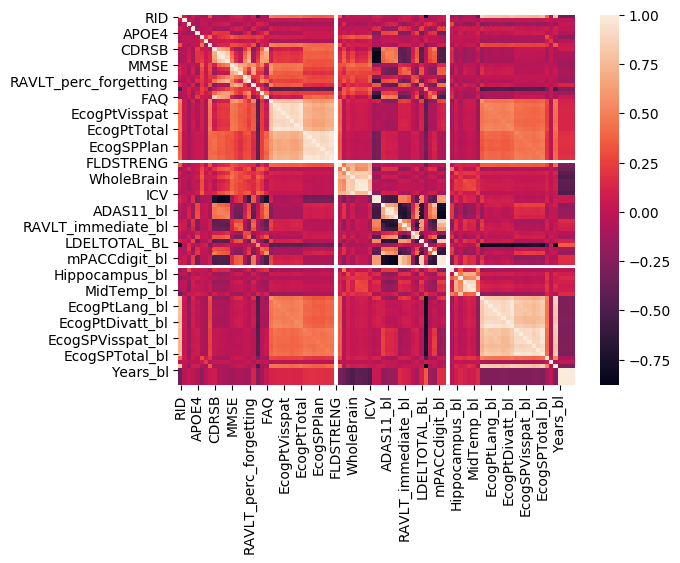

In [0]:
sns.heatmap(adni_num_df.fillna(0).corr())

Next we do the similar regression using biomarkers (ABETA, TAU, PTAU) and produce a correlation matrix between them. In the matrix I include MOCA and ADAS11 (Alzheimer's Disease Assessment Scale). Notice the highest correlation between biomarker and test is about .51 between the MOCA test and AV45. We see high correlation with biomarkers as well such as PTAU and TAU with .99 as well as ABETA and TAU at .74.

In [0]:
hold = adni_df

#fixing non-numeric values in biomarker columns
hold.ABETA[hold.ABETA=='>1700'] = 1700
hold.ABETA[hold.ABETA=='<200'] = 200
hold.TAU[hold.TAU=='>1300'] = 1300
hold.TAU[hold.TAU=='<80'] = 80
hold.PTAU[hold.PTAU=='>120'] = 120
hold.PTAU[hold.PTAU=='<8'] = 8

#convert to float
hold['PTAU'] = hold['PTAU'].astype(float)
hold['ABETA'] = hold['ABETA'].astype(float)
hold['TAU'] = hold['TAU'].astype(float)

#correlation matrix
hold[['APOE4','FDG','PIB','AV45','ABETA','TAU','PTAU', 'ADAS11', 'MOCA']].fillna(0).corr()

,APOE4,FDG,PIB,AV45,ABETA,TAU,PTAU,ADAS11,MOCA
APOE4,1.000000,-0.001075,0.025384,-0.009591,-0.080471,0.071441,0.082645,0.191868,-0.111241
FDG,-0.001075,1.000000,0.194506,0.440432,0.419959,0.381472,0.367044,0.170108,0.101676
PIB,0.025384,0.194506,1.000000,-0.058896,0.027439,0.067076,0.070684,0.065547,-0.103235
AV45,-0.009591,0.440432,-0.058896,1.000000,0.430535,0.430732,0.417957,0.129925,0.510908
ABETA,-0.080471,0.419959,0.027439,0.430535,1.000000,0.744702,0.698790,0.056007,0.201659
TAU,0.071441,0.381472,0.067076,0.430732,0.744702,1.000000,0.993284,0.184492,0.119492
PTAU,0.082645,0.367044,0.070684,0.417957,0.698790,0.993284,1.000000,0.184583,0.109584
ADAS11,0.191868,0.170108,0.065547,0.129925,0.056007,0.184492,0.184583,1.000000,0.081957
MOCA,-0.111241,0.101676,-0.103235,0.510908,0.201659,0.119492,0.109584,0.081957,1.000000


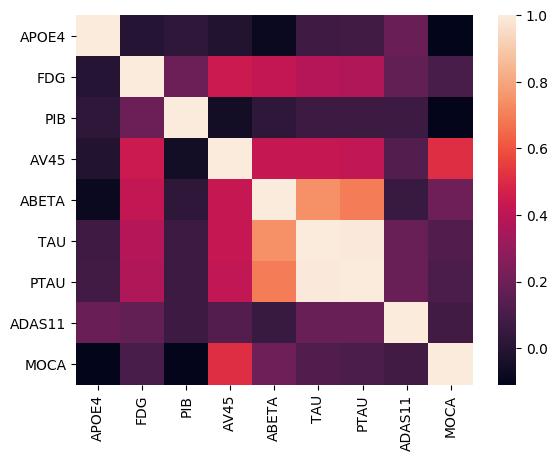

In [0]:
#sns.heatmap(hold[['APOE4','FDG','PIB','AV45','ABETA','TAU','PTAU', 'ADAS11', 'MOCA']].fillna(0).corr())

Next I run a couple of regression models with the dependent variables as the biomarkers and the independt as either MOCA or ADAS11. I chose to remove PTAU as one of the covariates due to its high correlation with TAU. Both models have an R-squared / Goodness of Fit of approx 40%. Looking at the coefficients and their respective p-values, all  look significant using a significance level of 5% except FDG with regards to MOCA.

In [0]:
reg_hold = hold[["MOCA",'APOE4','FDG','PIB','AV45','ABETA','TAU','PTAU', 'ADAS11']].fillna(0)
x = reg_hold[['APOE4','FDG','PIB','AV45','ABETA','TAU']]
y = reg_hold["MOCA"]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MOCA   R-squared (uncentered):                   0.438
Model:                            OLS   Adj. R-squared (uncentered):              0.437
Method:                 Least Squares   F-statistic:                              1773.
Date:                Thu, 20 Feb 2020   Prob (F-statistic):                        0.00
Time:                        17:40:36   Log-Likelihood:                         -52857.
No. Observations:               13673   AIC:                                  1.057e+05
Df Residuals:                   13667   BIC:                                  1.058e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
APOE4          3.7166      0.128     28.923      0.000       3.465       3.968
FDG           -0.0946      0.216     -0.438      0.662      -0.518       0.329
PIB           -0.8828      0.441     -2.002      0.045      -1.747      -0.019
AV45          16.7108      0.247     67.640      0.000      16.227      17.195
ABETA          0.0066      0.000     17.412      0.000       0.006       0.007
TAU           -0.0198      0.001    -15.948      0.000      -0.022      -0.017
==============================================================================
Omnibus:                     1500.960   Durbin-Watson:                   1.357
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2057.911
Skew:                           0.949   Prob(JB):                         0.00
Kurtosis:                       2.920   Cond. No.                     2.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [0]:
x = reg_hold[['APOE4','FDG','PIB','AV45','ABETA','TAU']]
y = reg_hold["ADAS11"]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 ADAS11   R-squared (uncentered):                   0.394
Model:                            OLS   Adj. R-squared (uncentered):              0.393
Method:                 Least Squares   F-statistic:                              1478.
Date:                Thu, 20 Feb 2020   Prob (F-statistic):                        0.00
Time:                        17:40:33   Log-Likelihood:                         -49906.
No. Observations:               13673   AIC:                                  9.982e+04
Df Residuals:                   13667   BIC:                                  9.987e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
APOE4          5.7683      0.104     55.704      0.000       5.565       5.971
FDG            4.2080      0.174     24.162      0.000       3.867       4.549
PIB            1.6027      0.355      4.511      0.000       0.906       2.299
AV45           2.3974      0.199     12.042      0.000       2.007       2.788
ABETA         -0.0019      0.000     -6.383      0.000      -0.003      -0.001
TAU            0.0141      0.001     14.034      0.000       0.012       0.016
==============================================================================
Omnibus:                     3762.743   Durbin-Watson:                   1.324
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14118.811
Skew:                           1.340   Prob(JB):                         0.00
Kurtosis:                       7.195   Cond. No.                     2.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* In the following chart, we want to find out the conversion between different patient groups. Specifically, we picked out all the patients in ADNI2 and filtered out the total number of patients how had a visit in 2012 and at the same time had a visit record in 2015. By doing this, we ended up with 625 patients, and we created the pivot table below, we can see that after a 4-year period, 91 patients who were initially diagnosed as MCI were confirmed into Dementia group; 31 patients who were initially diagnosed as cognitive normal were confirmed into MCI group.

## Survival Curve
Now we try to use Kaplan Meier model to estimate a survival curve of getting memory concerns and AD.

The survival curve of AD shows that the probability of getting Alzheimers Disease accelarates with the increase of age rapidly. And the median_survival age to get AD is 87.8.

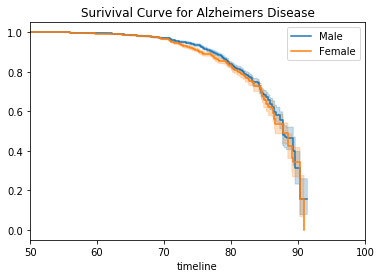

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

f = adni_df[['AGE','DX_bl','PTGENDER']].dropna(axis=0,how='any')
km = KaplanMeierFitter()
i1 = (f['PTGENDER'] == 'Male')
i2 = (f['PTGENDER'] == 'Female')
T = f['AGE']
E1 = (f['DX_bl']=='AD').astype(int)
km.fit(T[i1],E1[i1],label = 'Male')
a1 = km.plot()
km.fit(T[i2],E1[i2],label = 'Female')
km.plot(xlim=(50,100),ax=a1,title='Surivival Curve for Alzheimers Disease')


In [0]:
print('Median Survival Age:',km.median_survival_time_)

Median Survival Age: 87.8


The survival curve for memory concerns shows that the probability of getting memory concerns is not increased sharply by the increase of age, compared to the situation shown in the survival curve for AD. And the median_survival age to get memory concern is 77.

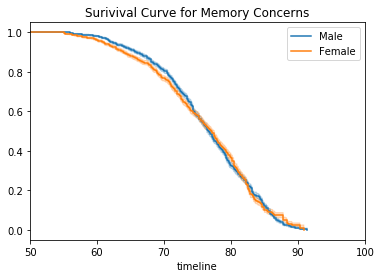

In [0]:
f = adni_df[['AGE','DX','PTGENDER']].dropna(axis=0,how='any')
km = KaplanMeierFitter()
i1 = (f['PTGENDER'] == 'Male')
i2 = (f['PTGENDER'] == 'Female')
T = f['AGE']
E1 = (f['DX']!='CN').astype(int)
km.fit(T[i1],E1[i1],label = 'Male')
a1 = km.plot()
km.fit(T[i2],E1[i2],label = 'Female')
km.plot(xlim=(50,100),ax=a1,title='Surivival Curve for Memory Concerns')


In [0]:
print('Median Survival Age:',km.median_survival_time_)

Median Survival Age: 77.0


The plot below show the survival curve of the probability of getting AD for those who already have memory concerns. The median survival time is 81, which is 7 years early then that in the first survival plot

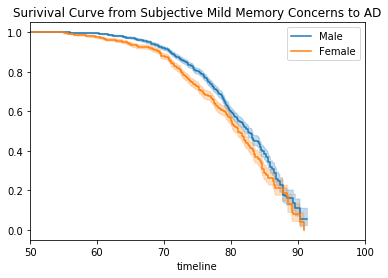

In [0]:
f = adni_df[['AGE','DX','PTGENDER']].dropna(axis=0,how='any').query('DX != "CN"')
km = KaplanMeierFitter()
i1 = (f['PTGENDER'] == 'Male')
i2 = (f['PTGENDER'] == 'Female')
T = f['AGE']
E1 = (f['DX']!='MCI').astype(int)
km.fit(T[i1],E1[i1],label = 'Male')
a1 = km.plot()
km.fit(T[i2],E1[i2],label = 'Female')
km.plot(xlim=(50,100),ax=a1,title='Surivival Curve from Subjective Mild Memory Concerns to AD')


In [0]:
print('Median Survival Age:',km.median_survival_time_)

Median Survival Age: 81.1


## Brain image example

In this section, we visualize one of the MRI image we downloaded from ADNI data. The structure for MRI data is a 3-D array, we use `matplotlib` to generate the gif below to show the 3-D image, one is to view from top down and the second gif is from the left side to right side.

![SegmentLocal](demo.gif "segment")
![SegmentLocal](demo2.gif "segment")

* Code to generate the above gifs    
    ```{python}
    fig = plt.figure()

    img = io.imread('ADNI_tmp.nii')
    #img = list(img)
    img2 = []
    for i in range(img.shape[2]):
        img2.append([plt.imshow(np.transpose(img[:,:,i]), animated=True)])
    ani = animation.ArtistAnimation(fig, img2, interval=50, blit=True,
                                    repeat_delay=1000)
    ani.save('demo2.gif', writer='imagemagick') 

    plt.show()
    ```